In [1]:
#B.Pagli 04/2023
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy as sc

from CRO import RO_solver
from CRO import RO_fitting

from math import floor

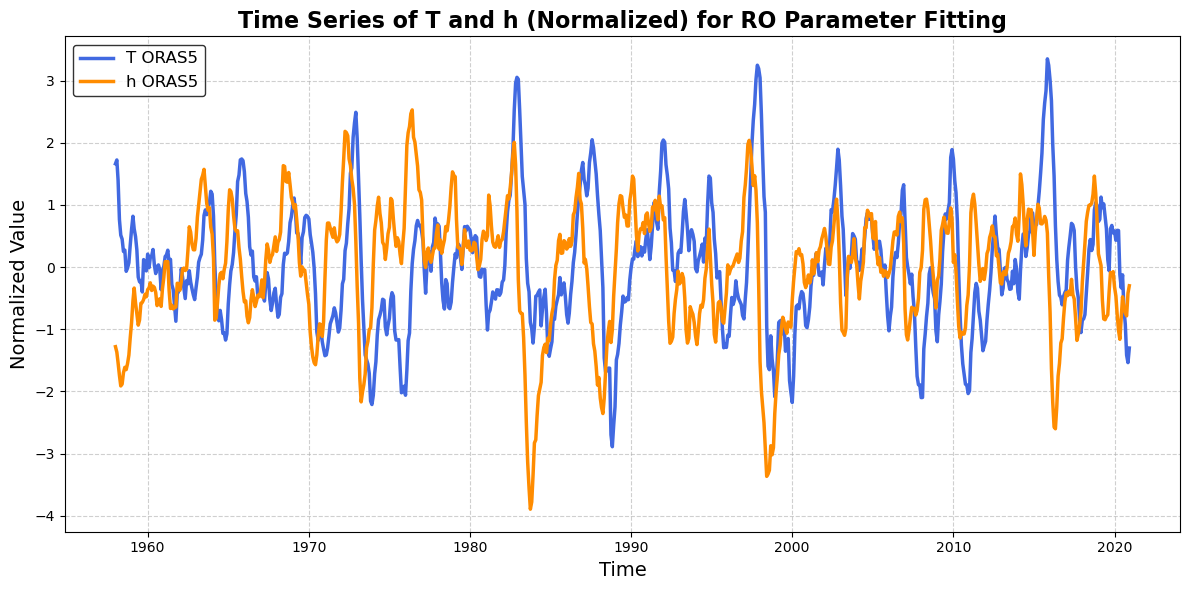

In [2]:
#Here we take Nino34 and Hw from the data downloaded from the drive https://drive.google.com/drive/folders/1h9kByJ1E7jmGjPPVyQTKhXh4qUsMX6oF?usp=share_link
#We normalize here T and h by their std over the time period
# Load dataset
t_and_h_oras5 = xr.open_dataset('../data/CROdata_timeseries_oras5.nc')
t_oras5 = t_and_h_oras5['Nino34']/ t_and_h_oras5['Nino34'].std(dim='time')
h_oras5 = t_and_h_oras5['Hm']/ t_and_h_oras5['Hm'].std(dim='time')

time_oras5 = t_and_h_oras5.time

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot data with better line styles
ax.plot(time_oras5, t_oras5, label='T ORAS5', color='royalblue', linewidth=2.5, linestyle='-')
ax.plot(time_oras5, h_oras5, label='h ORAS5', color='darkorange', linewidth=2.5, linestyle='-')

# Improve labels and title
ax.set_title('Time Series of T and h (Normalized) for RO Parameter Fitting', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Normalized Value', fontsize=14)

# Add a legend with better styling
ax.legend(fontsize=12, loc='best', frameon=True, edgecolor='black')

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Improve layout
plt.tight_layout()


In [2]:
method_fitting='LR-F'
dt_fitting=1.0
T_to_fit = t_oras5.values
h_to_fit = h_oras5.values

#Choose the type of RO to fit with T and h
T_option={'R': 3, 'F1': 3, 'b_T': 0, 'c_T': 0, 'd_T': 0} 
h_option={'F2': 3, 'epsilon': 3, 'b_h': 0} 
noise_option={'T': "white", 'h': "white", 'T_type': "additive"} 

fitted_param = RO_fitting(T=T_to_fit,h=h_to_fit,T_option=T_option, h_option=h_option, noise_option=noise_option, method_fitting=method_fitting,dt_fitting=1.0,)
fitted_param

NameError: name 't_oras5' is not defined

In [1]:

#Call RO_solver with parameters obtained on ORAS5 dataset.
#And generation of NE synthetic timeseries with the fitted parameters 

par = fitted_param

IC = [0.2,0.02] #Initial condition, arbitrary choice here
N = 100*12 #Lenght of the time series in month
NE = 5 #Number of members to generate
EF = {'E_T':0.0,'E_h':0.0} #External forcing, null here.
NM='EH' # numerical scheme
dt=0.1 #dt used in RO solver in month
saveat=1.0 #save every saveat month, needs to be an integer multiple of dt

t = np.array([j*dt for j in range(floor((N-1)/dt)+1)])[::int(round(saveat / dt))]

#Call the RO solver function
#This returns an ensemble of NE members of T,h and the white noises used for integration
T,h,_ = RO_solver(par=par,IC=IC,N=N,NE=NE,EF=EF,NM=NM,dt=dt,saveat=saveat,noise_custom=[])


NameError: name 'fitted_param' is not defined

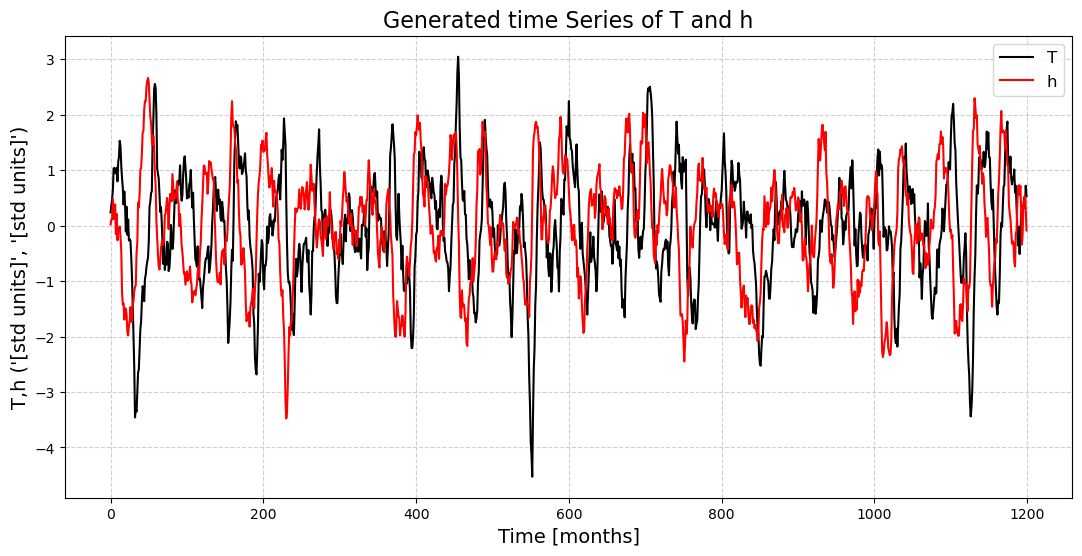

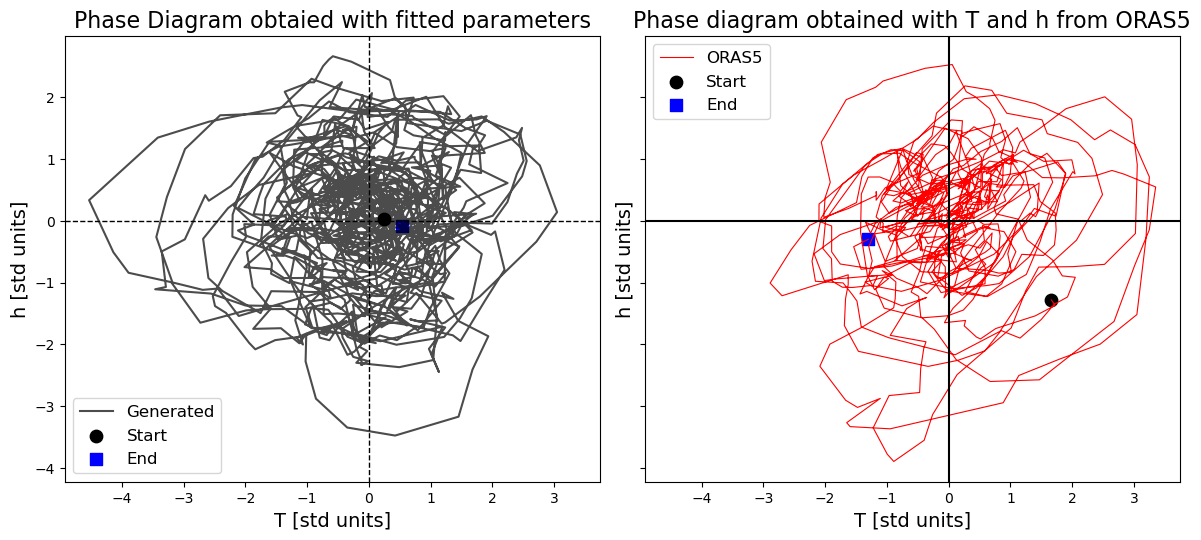

In [5]:
#plot for one member of the synthetic RO ensemble the phase space and T,h time series
# The phase space of the observations is also shown
normalized=True
idx_ens=3
if normalized:
    unit_T = '[std units]'
    unit_h = '[std units]'
    T_idx = T[idx_ens]/(np.nanstd(T[idx_ens]))
    h_idx =  h[idx_ens]/(np.nanstd(h[idx_ens]))
else:
    unit_T = '[K]'
    unit_h = '[m]'
    T_idx = T[idx_ens]
    h_idx =  h[idx_ens]

fig, ax1 = plt.subplots(figsize=(13, 6))
ax1.plot(t, T_idx, 'k', linewidth=1.5, label='T')
ax1.plot(t, h_idx, 'r', linewidth=1.5, label='h')

ax1.set_xlabel('Time [months]', fontsize=14)
ax1.set_ylabel(f'T,h {unit_T,unit_h}', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_title('Generated time Series of T and h', fontsize=16)

# Phase Diagram Plot
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(12, 6),sharey=True, sharex=True)
ax1.plot(T_idx, h_idx, linewidth=1.5, color='k', alpha=0.7, label="Generated")
ax1.scatter(T_idx[0], h_idx[0], marker='o', color='black', s=80, label="Start")
ax1.scatter(T_idx[-1], h_idx[-1], marker='s', color='blue', s=80, label="End")
ax1.set_xlabel(f'T {unit_T}', fontsize=14)
ax1.set_ylabel(f'h {unit_h}', fontsize=14)
ax1.axvline(x=0, color="k", linestyle="--", linewidth=1)
ax1.axhline(y=0, color="k", linestyle="--", linewidth=1)
ax1.set_aspect('equal', 'box')
ax1.legend(fontsize=12)
ax1.set_title('Phase Diagram obtaied with fitted parameters', fontsize=16)

ax2.plot(t_oras5,h_oras5,linewidth=0.8,c='r', label='ORAS5')
ax2.scatter(t_oras5[0], h_oras5[0], marker='o', color='black', s=80, label="Start")
ax2.scatter(t_oras5[-1], h_oras5[-1], marker='s', color='blue', s=80, label="End")
ax2.set_xlabel('T '+unit_T, fontsize=14)
ax2.set_ylabel('h '+unit_h, fontsize=14)
ax2.set_aspect('equal', 'box')
ax2.axvline(x=0, c="k")
ax2.axhline(y=0, c="k")
ax2.set_title('Phase diagram obtained with T and h from ORAS5', fontsize=16)
ax2.legend(fontsize=12)

plt.tight_layout()

In [6]:
#Store the results of the different memebers generated in an xarray with an artificial calendar time axis of N months, for time series calculations.
time = pd.date_range('1900-01-01', '1999-12-01',freq='MS')
Th = xr.Dataset(
        data_vars = dict(
            T = ([ "membre","time"], T),
            h = ([ "membre","time"], h),
            ),
        coords = dict(
            time = time,
            membre = np.arange(0,NE)
            ),
        attrs = dict()
)

In [7]:
#Here we recreate the seasonal cycle for each parameters as time series from the three parameters necessary for 
#3-seasonal cycle 

time_discr = np.array([i for i in range(time.size)])
def reconstruct_seasonal_param(var,time_discr):
    try:
        A = fitted_param[var][0]
        Aa = fitted_param[var][1]
        phia = fitted_param[var][2]
        sc = A + Aa*np.sin(2*np.pi/12*time_discr + phia)
    except:
        A = fitted_param[var]
        sc = A + 0.*np.sin(2*np.pi/12*time_discr) 
    return sc

sc_R = reconstruct_seasonal_param('R',time_discr)
sc_epsilon = reconstruct_seasonal_param('epsilon',time_discr)
sc_F1 = reconstruct_seasonal_param('F1',time_discr)
sc_F2 = reconstruct_seasonal_param('F2',time_discr)


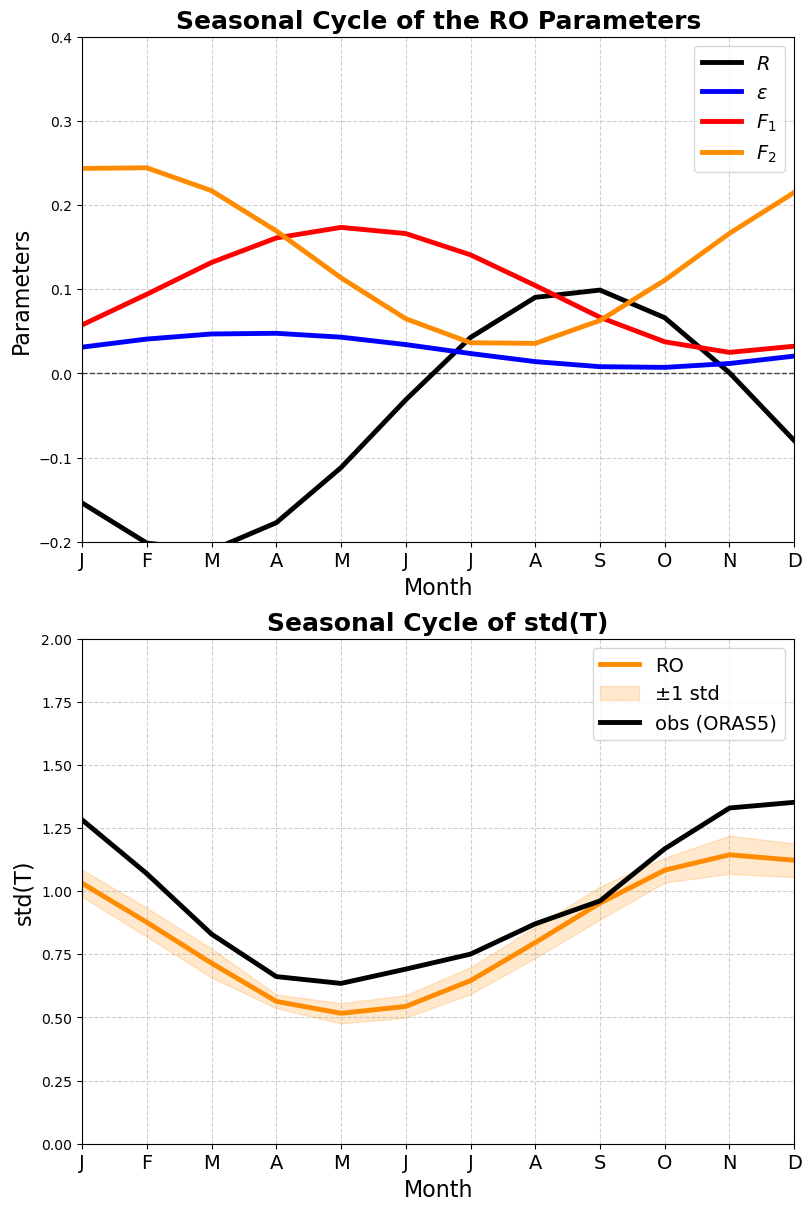

In [8]:
#Look at the seasonality obtained in the parameters R,epsilon,F1,F2 and the seasonal synchronization of the synthtetic T_E time series generated
#Here we store the parameters time series in an xarray with a time axis to facilitate the groupby month calculations
param_sc = xr.Dataset(
        data_vars = dict(
            R = ([ "time"], sc_R),
            epsilon = ([ "time"], sc_epsilon),
            F1 = ([ "time"], sc_F1),
            F2 = ([ "time"], sc_F2),
            ),
        coords = dict(
            time = time,
            ),
        attrs = dict()
)

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

ldt = 3.5  # Line width for curves
fig, axs = plt.subplots(2, 1, figsize=(8, 12), constrained_layout=True)

# Color palette
colors = {
    "R": "black",
    "epsilon": "blue",
    "F1": "red",
    "F2": "darkorange",
    "RO": "darkorange",
    "obs": "black"
}

# --- First Plot: Seasonal Cycle of RO Parameters ---
ax = axs[0]
param_sc.groupby('time.month').mean()['R'].plot(label='$R$', color=colors["R"], linewidth=ldt, ax=ax)
param_sc.groupby('time.month').mean()['epsilon'].plot(label='$\epsilon$', color=colors["epsilon"], linewidth=ldt, ax=ax)
param_sc.groupby('time.month').mean()['F1'].plot(label='$F_1$', color=colors["F1"], linewidth=ldt, ax=ax)
param_sc.groupby('time.month').mean()['F2'].plot(label='$F_2$', color=colors["F2"], linewidth=ldt, ax=ax)

ax.axhline(0, color='k', linewidth=1, linestyle='--', alpha=0.7)
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'], fontsize=14)
ax.set_xlim(1, 12)
ax.set_ylim(-0.2, 0.4)
ax.set_ylabel('Parameters', fontsize=16)
ax.set_xlabel('Month', fontsize=16)
ax.legend(fontsize=14, loc='upper right', frameon=True)
ax.set_title('Seasonal Cycle of the RO Parameters', fontsize=18, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# --- Second Plot: Seasonal Cycle of std(T) ---
ax1 = axs[1]

# Mean std(T) for synthetic ensemble (RO)
std_T_mean = Th['T'].groupby('time.month').std().mean(dim='membre')
std_T_std = Th['T'].groupby('time.month').std().std(dim='membre')

# Plot the mean
std_T_mean.plot(ax=ax1, label='RO', color=colors["RO"], linewidth=ldt)

# Plot the shaded confidence interval (±1 std)
ax1.fill_between(std_T_mean['month'], std_T_mean - std_T_std, std_T_mean + std_T_std, 
                 color=colors["RO"], alpha=0.2, label="±1 std")

# Observed data (ORAS5)
t_oras5.groupby('time.month').std().plot(ax=ax1, label='obs (ORAS5)', linewidth=ldt, color=colors["obs"])

ax1.set_xticks(np.arange(1, 13))
ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'], fontsize=14)
ax1.set_xlim(1, 12)
ax1.set_ylim(0, 2)
ax1.set_ylabel('std(T)', fontsize=16)
ax1.set_xlabel('Month', fontsize=16)
ax1.legend(fontsize=14, loc='upper right', frameon=True)
ax1.set_title('Seasonal Cycle of std(T)', fontsize=18, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)

# Show the final improved plot
plt.show()
